In [ ]:
Name = 'Parsa Ghezelbash'
STID = 401110437

In [1]:
import numpy as np



import matplotlib.pyplot as plt







import torch



import torch.nn as nn



import torch.nn.functional as F



import torch.optim as optim



from torch.utils.data import Subset



from torch.utils.data import DataLoader



from torch.utils.data import random_split







import torchvision



import torchvision.transforms as transforms



from torchvision.models import resnet50, ResNet50_Weights







from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



from sklearn.preprocessing import OneHotEncoder







import time







import importlib



import utils.utils as utils







importlib.reload(utils)



from utils.utils import (



    accuracy,



    train,



    combined_train,



    test,



    combined_test,



    plot_acc,



    plot_loss,



    plot_confusion_matrix,



    save_model,



    get_feature_maps,



    visualize_feature_maps,



    plot_images,



    plot_feature_maps,



)


# Loading CIFAR10 + Preprocess

In [2]:
class OneHotEncode:



    def __init__(self, num_classes):



        self.num_classes = num_classes







    def __call__(self, label):



        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [3]:
train_size = 50000



val_size = 10000



test_size = 10000



mean = [0.485, 0.456, 0.406]



std = [0.229, 0.224, 0.225]



num_classes = 2







torch.manual_seed(13)



np.random.seed(13)







transform = transforms.Compose(



    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]



)







label_transform = OneHotEncode(num_classes=num_classes)







train_dataset = torchvision.datasets.CIFAR10(



    root="./data",



    train=True,



    download=True,



    transform=transform,



    target_transform=label_transform,



)







test_dataset = torchvision.datasets.CIFAR10(



    root="./data",



    train=False,



    download=True,



    transform=transform,



    target_transform=label_transform,



)

100%|██████████| 170498071/170498071 [01:26<00:00, 1977310.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Extracting <kbd>airplane</kbd> and <kbd>automobile</kbd>

In [4]:
classes = train_dataset.classes



automobile_index = train_dataset.class_to_idx["automobile"]



airplane_index = train_dataset.class_to_idx["airplane"]











print(classes)



print(f"automobile: {automobile_index}")



print(f"airplane: {airplane_index}")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
automobile: 1
airplane: 0


In [5]:
indices = [airplane_index, automobile_index]



classes = np.array(classes)[indices].tolist()







train_indices = np.where(np.isin(train_dataset.targets, indices))[0]



test_indices = np.where(np.isin(test_dataset.targets, indices))[0]







train_subset = Subset(train_dataset, train_indices)



test_subset = Subset(test_dataset, test_indices)







train_subset, val_subset = random_split(train_subset, [0.8, 0.2])

In [6]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)



val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)



test_loader = DataLoader(test_subset, batch_size=64, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print(f"device: {device.type}")

device: cuda


# Defining Model

In [8]:
class CombinedModel(nn.Module):



    def __init__(self, embedding_size=128, num_classes=10):



        super(CombinedModel, self).__init__()



        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)



        num_features = self.backbone.fc.in_features







        self.backbone.fc = nn.Identity()



        self.embedding = nn.Linear(num_features, embedding_size)



        self.classifier = nn.Linear(num_features, num_classes)







    def forward(self, x):



        features = self.backbone(x)







        embeddings = nn.functional.normalize(self.embedding(features), p=2, dim=1)



        class_scores = self.classifier(features)



        return embeddings, class_scores

# 1) Cross Entropy Loss

## Loading Pre-Trained Model


In [9]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)



num_features = model.fc.in_features



model.fc = nn.Linear(num_features, num_classes)







for param in model.parameters():



    param.requires_grad = False







for param in model.fc.parameters():



    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [10]:
model.to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.Adam(model.fc.parameters())

## Training ResNet50 for Classification

In [11]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 22.61, Train acc: 0.853, Val loss: 22.28, Val acc: 0.867
Epoch 10/30, Train loss: 23.281, Train acc: 0.849, Val loss: 24.606, Val acc: 0.866
Epoch 15/30, Train loss: 22.875, Train acc: 0.854, Val loss: 23.693, Val acc: 0.86
Epoch 20/30, Train loss: 22.614, Train acc: 0.853, Val loss: 25.114, Val acc: 0.856
Epoch 25/30, Train loss: 22.881, Train acc: 0.852, Val loss: 23.578, Val acc: 0.86
Epoch 30/30, Train loss: 22.151, Train acc: 0.857, Val loss: 24.953, Val acc: 0.854
time: 124.84 seconds


## Plotting Loss and Accuracy

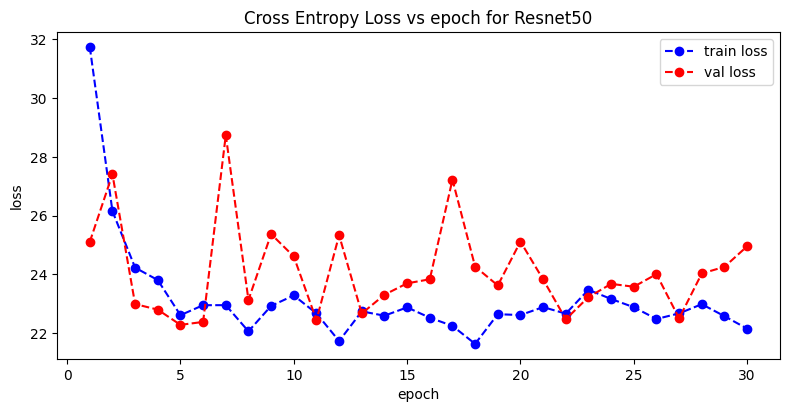

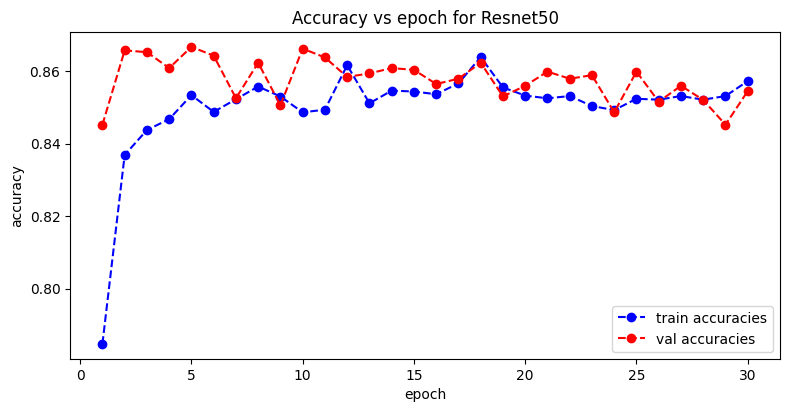

In [12]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for Resnet50",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for Resnet50",



)

loss= 24.463, accuracy= 0.849


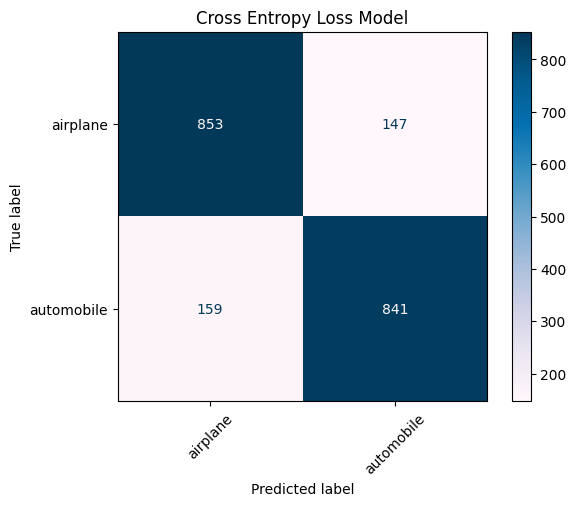

In [13]:
loss, acc, preds, labels = test(



    model, test_loader, criterion, device



)



print(f"loss= {np.round(loss, 3)}, accuracy= {np.round(acc, 3)}")



plot_confusion_matrix(labels, preds, class_names=classes, title="Cross Entropy Loss Model")

## Plotting Feature Maps

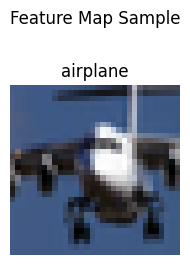

feature map size: torch.Size([1, 64, 16, 16])


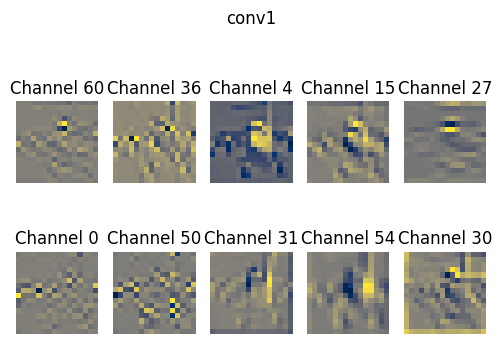

feature map size: torch.Size([1, 256, 8, 8])


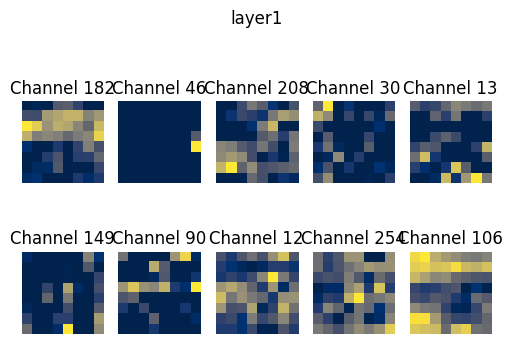

feature map size: torch.Size([1, 512, 4, 4])


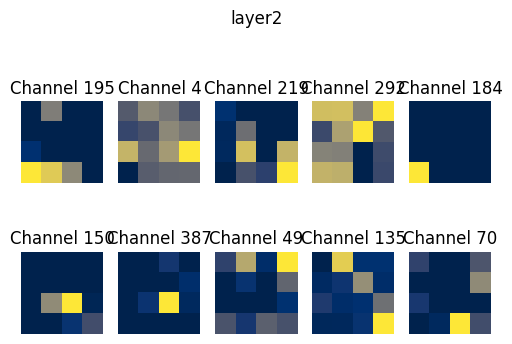

feature map size: torch.Size([1, 1024, 2, 2])


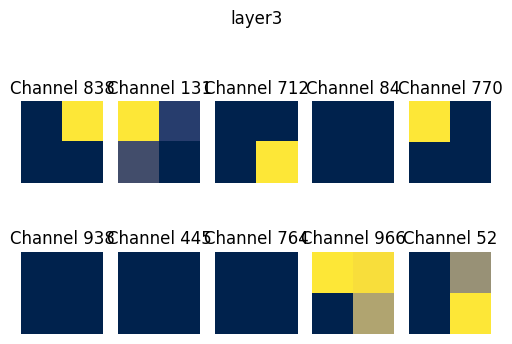

In [14]:
images, labels = next(iter(train_loader))



image, label = images[0], classes[torch.argmax(labels[0])]



plot_images([image], mean, std, [label], title="Feature Map Sample")







plot_feature_maps(model, image, device)

# 2) Triplet Loss

## Preparing Dataset

In [15]:
class TripletDataset(torch.utils.data.Dataset):



    def __init__(self, dataset, triplets):



        self.dataset = dataset



        self.triplets = triplets







    def __len__(self):



        return len(self.triplets)







    def __getitem__(self, idx):



        anchor_idx, positive_idx, negative_idx = self.triplets[idx]



        anchor, label = self.dataset[anchor_idx]



        positive, _ = self.dataset[positive_idx]



        negative, _ = self.dataset[negative_idx]



        return (anchor, positive, negative), label











def make_triplets(dataset):



    triplets = []



    class_indices = {}







    for idx, (_, label) in enumerate(dataset):



        c = classes[torch.argmax(label)]



        if c not in class_indices:



            class_indices[c] = []



        class_indices[c].append(idx)







    for c in class_indices:



        for idx in class_indices[c]:



            anchor_idx = idx







            positive_idx = np.random.choice(



                [i for i in class_indices[c] if i != anchor_idx]



            )







            negative_class = np.random.choice(



                [label for label in class_indices.keys() if label != c]



            )



            negative_idx = np.random.choice(class_indices[negative_class])







            triplets.append((anchor_idx, positive_idx, negative_idx))







    return triplets

## Making Triplets

In [16]:
trian_triplets = make_triplets(train_subset)



val_triplets = make_triplets(val_subset)



test_triplets = make_triplets(test_subset)







train_triplet_dataset = TripletDataset(train_subset, trian_triplets)



val_triplet_dataset = TripletDataset(val_subset, val_triplets)



test_triplet_dataset = TripletDataset(test_subset, test_triplets)

In [17]:
train_loader = DataLoader(



    train_triplet_dataset, batch_size=64, shuffle=True



)



val_loader = DataLoader(val_triplet_dataset, batch_size=64, shuffle=True)



test_loader = DataLoader(



    test_triplet_dataset, batch_size=64, shuffle=True



)

## Training ResNet50 for Feature Extracting + Feature Maps

In [18]:
num_embeddings = 128



triplet_model = CombinedModel(embedding_size=num_embeddings, num_classes=num_classes)

In [19]:
triplet_model.to(device)



criterion = nn.TripletMarginLoss(margin=1, p=2)



optimizer = optim.Adam(triplet_model.parameters())

Epoch 5/30, Train loss: 5.111, Train acc: 0.138, Val loss: 11.504, Val acc: 0.225
feature map size: torch.Size([1, 64, 16, 16])


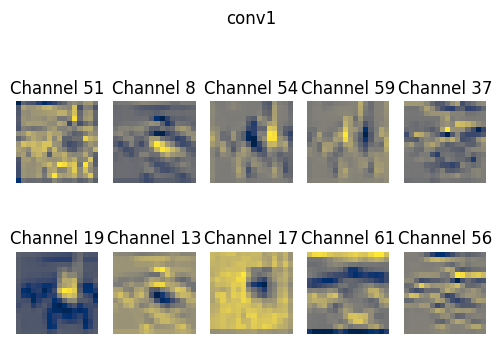

feature map size: torch.Size([1, 256, 8, 8])


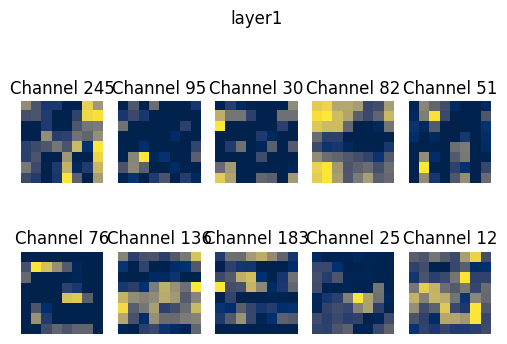

feature map size: torch.Size([1, 512, 4, 4])


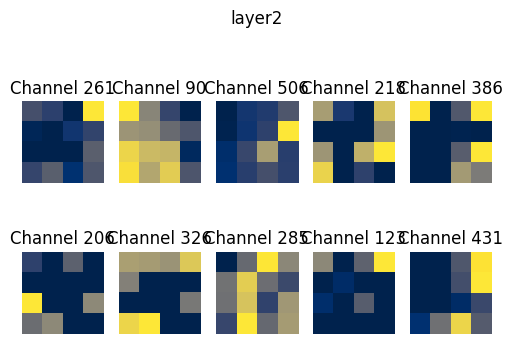

feature map size: torch.Size([1, 1024, 2, 2])


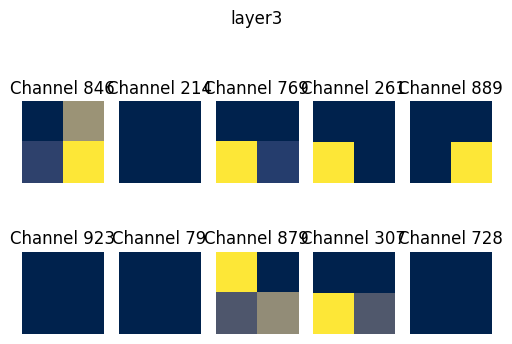

Epoch 10/30, Train loss: 5.492, Train acc: 0.24, Val loss: 9.758, Val acc: 0.125
feature map size: torch.Size([1, 64, 16, 16])


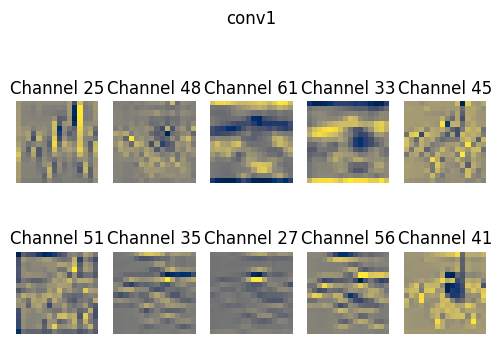

feature map size: torch.Size([1, 256, 8, 8])


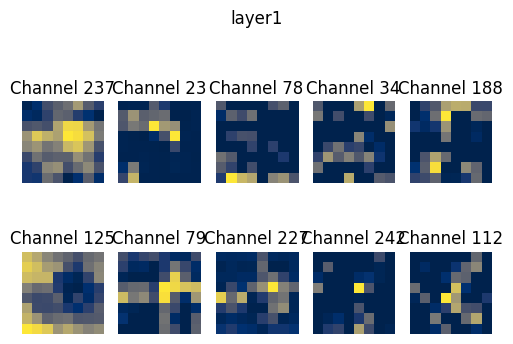

feature map size: torch.Size([1, 512, 4, 4])


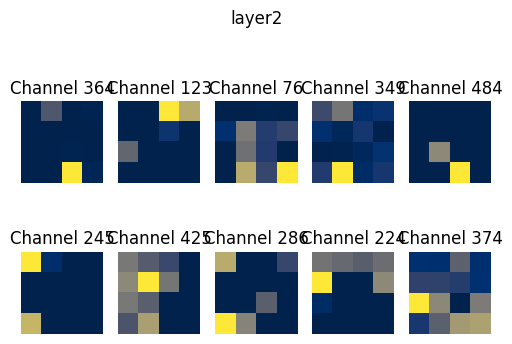

feature map size: torch.Size([1, 1024, 2, 2])


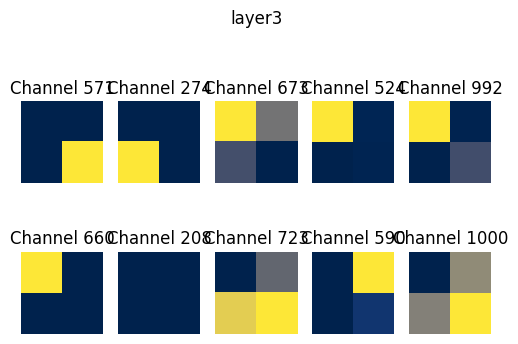

Epoch 15/30, Train loss: 2.178, Train acc: 0.294, Val loss: 9.394, Val acc: 0.242
feature map size: torch.Size([1, 64, 16, 16])


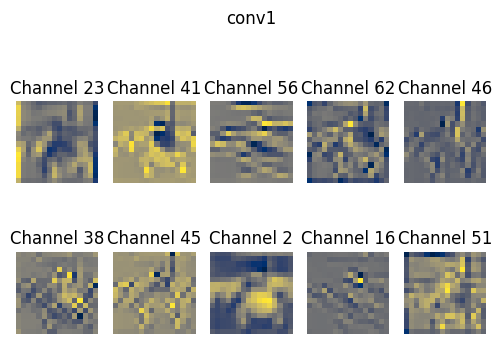

feature map size: torch.Size([1, 256, 8, 8])


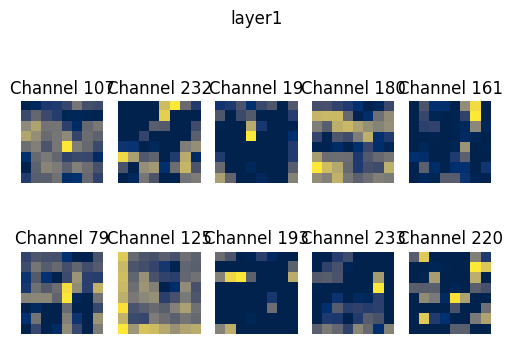

feature map size: torch.Size([1, 512, 4, 4])


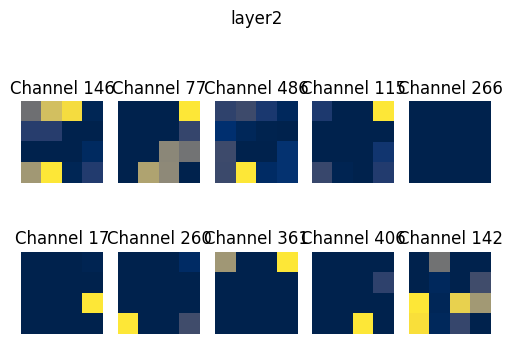

feature map size: torch.Size([1, 1024, 2, 2])


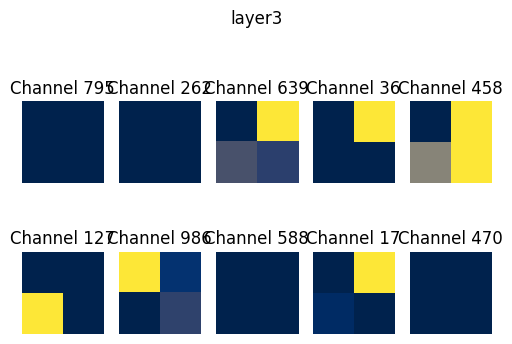

Epoch 20/30, Train loss: 9.258, Train acc: 0.154, Val loss: 8.605, Val acc: 0.135
feature map size: torch.Size([1, 64, 16, 16])


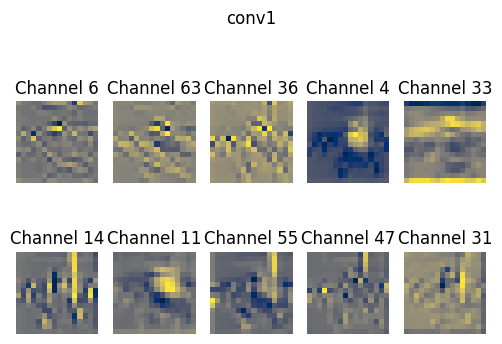

feature map size: torch.Size([1, 256, 8, 8])


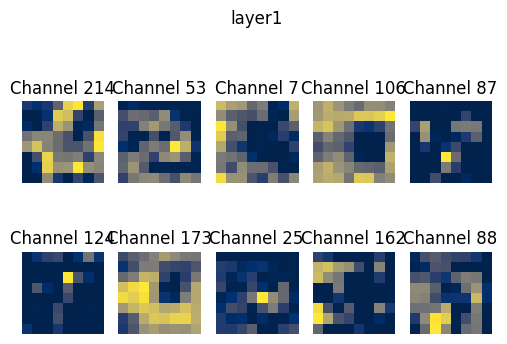

feature map size: torch.Size([1, 512, 4, 4])


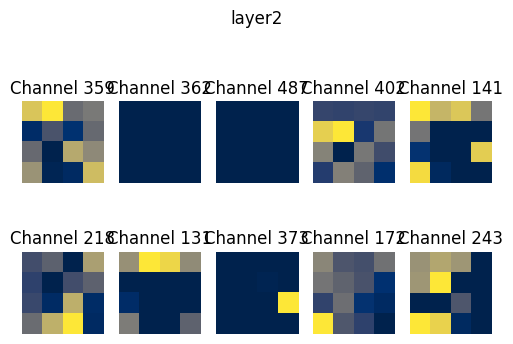

feature map size: torch.Size([1, 1024, 2, 2])


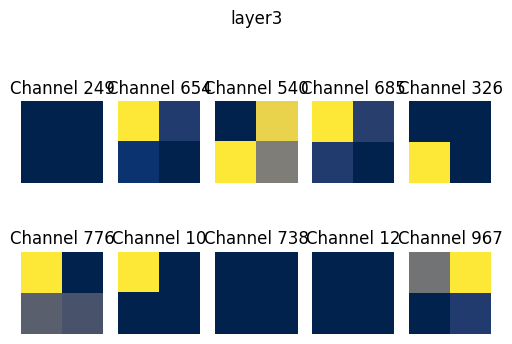

Epoch 25/30, Train loss: 0.713, Train acc: 0.187, Val loss: 8.197, Val acc: 0.045
feature map size: torch.Size([1, 64, 16, 16])


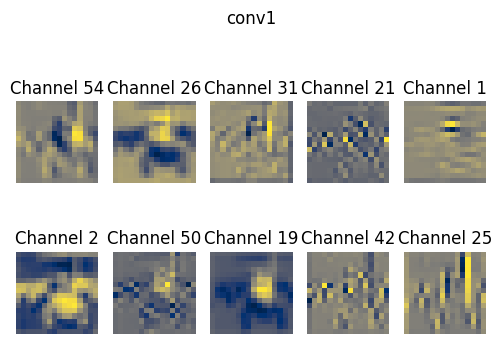

feature map size: torch.Size([1, 256, 8, 8])


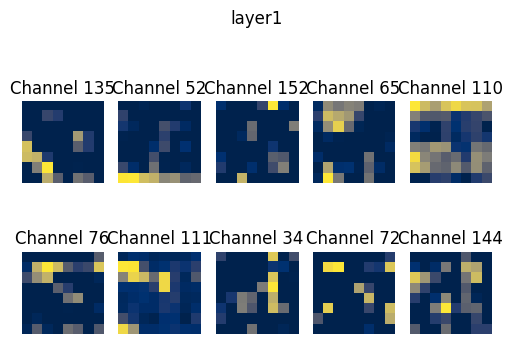

feature map size: torch.Size([1, 512, 4, 4])


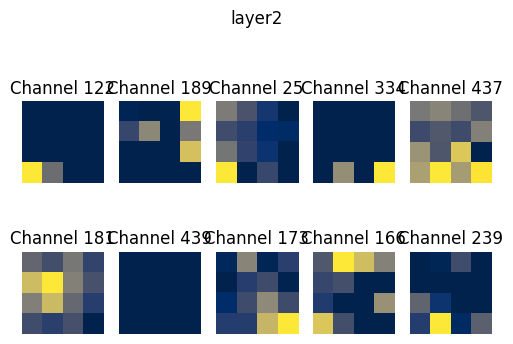

feature map size: torch.Size([1, 1024, 2, 2])


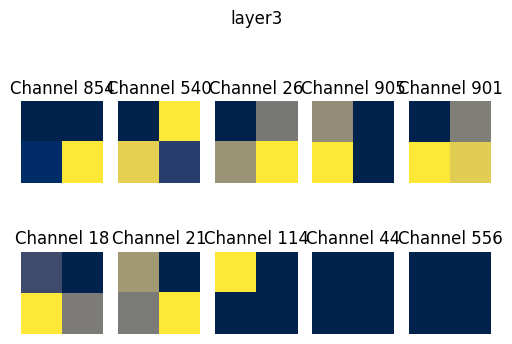

Epoch 30/30, Train loss: 5.831, Train acc: 0.237, Val loss: 12.862, Val acc: 0.088
feature map size: torch.Size([1, 64, 16, 16])


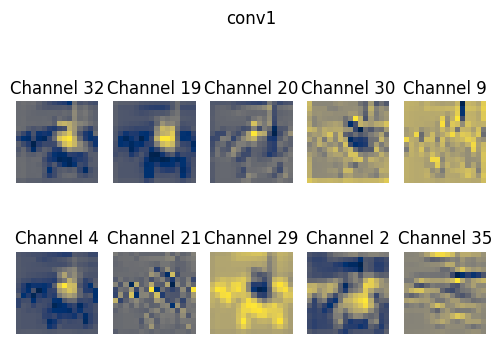

feature map size: torch.Size([1, 256, 8, 8])


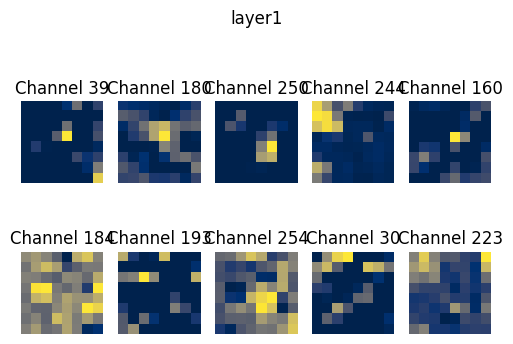

feature map size: torch.Size([1, 512, 4, 4])


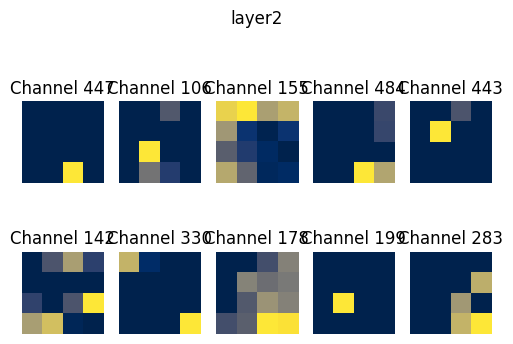

feature map size: torch.Size([1, 1024, 2, 2])


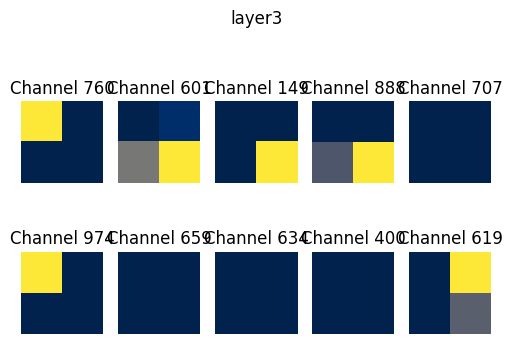

time: 738.69 seconds


In [22]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = (



    combined_train(



        model=triplet_model,



        train_loader=train_loader,



        val_loader=val_loader,



        optimizer=optimizer,



        criterion=criterion,



        device=device,



        image=image,

        
        
        feature_model=triplet_model.backbone,


        
        epochs=epochs,



        log=True,



        mode="triplet",



    )



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

## Plotting Loss

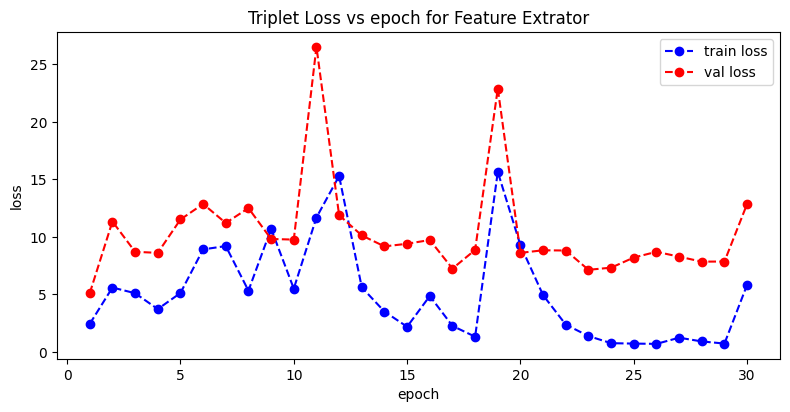

In [23]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Triplet Loss vs epoch for Feature Extrator",



)

## Training ResNet50 for Classification

In [24]:
for param in triplet_model.parameters():



    param.requires_grad = False







for param in triplet_model.classifier.parameters():



    param.requires_grad = True

In [25]:
triplet_model.to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.Adam(triplet_model.classifier.parameters())

In [26]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = (



    combined_train(



        model=triplet_model,



        train_loader=train_loader,



        val_loader=val_loader,



        optimizer=optimizer,



        criterion=criterion,



        device=device,



        epochs=epochs,



        log=True,



        mode="default",



    )



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 7.716, Train acc: 0.973, Val loss: 10.114, Val acc: 0.952
Epoch 10/30, Train loss: 6.379, Train acc: 0.973, Val loss: 9.594, Val acc: 0.955
Epoch 15/30, Train loss: 6.392, Train acc: 0.972, Val loss: 9.755, Val acc: 0.955
Epoch 20/30, Train loss: 5.968, Train acc: 0.971, Val loss: 9.516, Val acc: 0.958
Epoch 25/30, Train loss: 6.226, Train acc: 0.972, Val loss: 9.964, Val acc: 0.954
Epoch 30/30, Train loss: 6.012, Train acc: 0.972, Val loss: 9.888, Val acc: 0.955
time: 373.53 seconds


## Plotting Loss and Accuracy

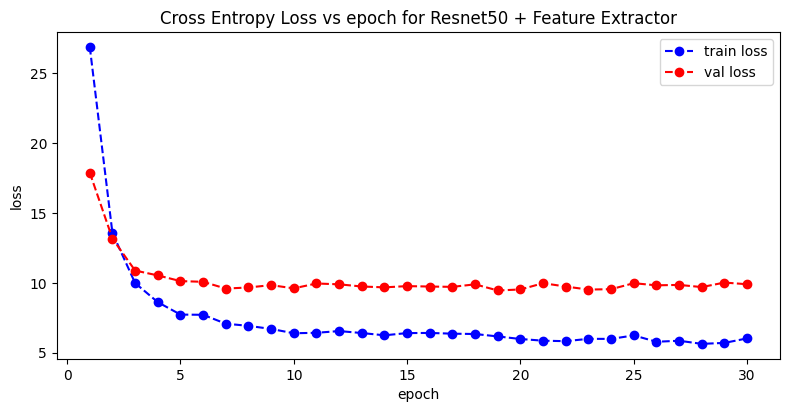

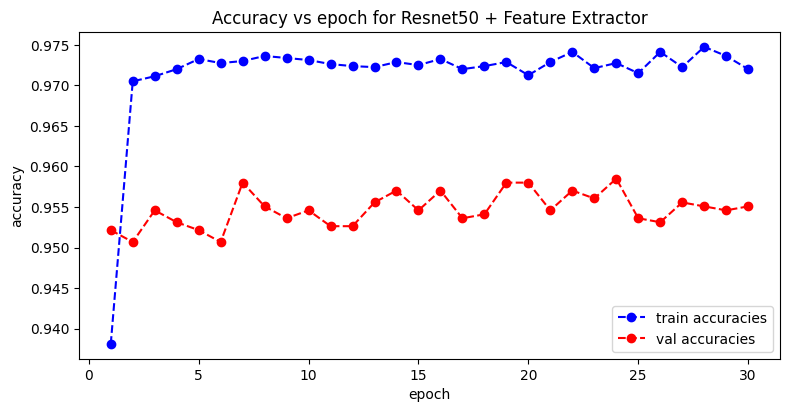

In [27]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for Resnet50 + Feature Extractor",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for Resnet50 + Feature Extractor",



)

## Testing on Test Dataset

loss= 9.616, accuracy= 0.956


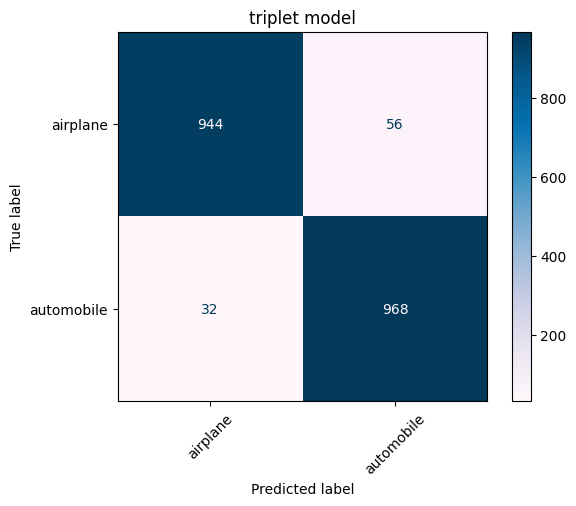

In [28]:
loss, acc, preds, labels = combined_test(



    triplet_model, test_loader, criterion, device, mode="default"



)



print(f"loss= {np.round(loss, 3)}, accuracy= {np.round(acc, 3)}")



plot_confusion_matrix(labels, preds, class_names=classes, title="triplet model")

feature maps improved with triplet loss as you can see in the last epoch of training feature extractor.

# 3) Conclusion and Comparison

* <b>Feature Map:</b> Triplet method constructed better feature maps extracted more specific features.

* <b>Accuracy:</b> Using triplet method we will achieve a higher accuracy.

* <b>Convergance:</b> triplet method converged faster in 30 epochs than regular method with Cross Entropy.

# 4) Loss Combination

In [30]:
num_embeddings = 128



combined_model = CombinedModel(embedding_size=num_embeddings, num_classes=num_classes)

In [32]:
combined_model.to(device)



criterion = [nn.CrossEntropyLoss(), nn.TripletMarginLoss(margin=1, p=2)]



optimizer = optim.Adam(combined_model.parameters())

In [33]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = (



    combined_train(



        model=combined_model,



        train_loader=train_loader,



        val_loader=val_loader,



        optimizer=optimizer,



        criterion=criterion,



        device=device,



        epochs=epochs,



        log=True,



        mode="combined",



    )



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 3.693, Train acc: 0.991, Val loss: 9.333, Val acc: 0.977
Epoch 10/30, Train loss: 2.689, Train acc: 0.993, Val loss: 20.237, Val acc: 0.962
Epoch 15/30, Train loss: 0.546, Train acc: 0.999, Val loss: 11.868, Val acc: 0.973
Epoch 20/30, Train loss: 0.754, Train acc: 0.998, Val loss: 10.373, Val acc: 0.975
Epoch 25/30, Train loss: 2.171, Train acc: 0.994, Val loss: 17.339, Val acc: 0.964
Epoch 30/30, Train loss: 1.051, Train acc: 0.997, Val loss: 15.685, Val acc: 0.971
time: 733.6 seconds


## Testing on Test Dataset

loss= 14.254, accuracy= 0.974


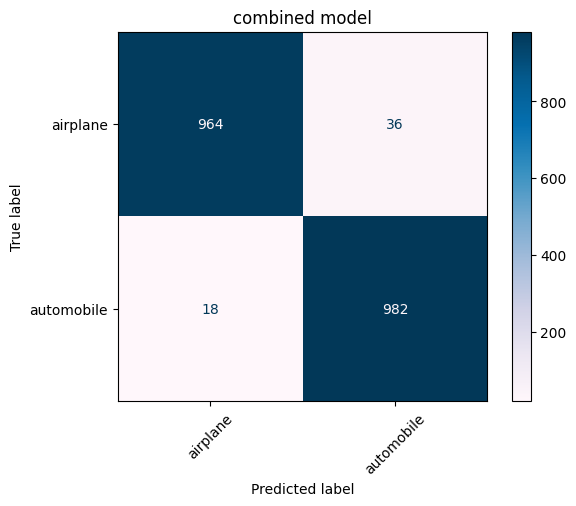

In [35]:
loss, acc, preds, labels = combined_test(



    combined_model, test_loader, criterion, device, mode="combined"



)



print(f"loss= {np.round(loss, 3)}, accuracy= {np.round(acc, 3)}")



plot_confusion_matrix(labels, preds, class_names=classes, title="combined model")

Training both Feature Extractor and Classifier at the same time leads to higher accuracy becausae the weights of ResNet50 are learning to optimize Feature Extraction and Classificaiton 

and will lead to better Classifier in Comparison with the model where are optimizing Feature Extraction alone.